#Task 4


#Testing with a Second Dataset and Developing Performance Metrics

In [23]:
%%capture
!pip install folium
!pip install osmnx
!pip install geopandas
%matplotlib inline
%osmnx inline
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point
import time
# from fastai.structured import *
from sklearn import metrics
# from fastai.imports import *
from sklearn.ensemble import RandomForestRegressor


Loading and prepairing the second dataset (NYC taxi mobility data)

In [24]:
print("Loading NYC taxi mobility data...")
nyc_taxi_data_url = "https://github.com/IsamAljawarneh/datasets/raw/master/data/nyc1.zip"
taxi_data = pd.read_csv(nyc_taxi_data_url, compression='zip')
taxi_data.shape[0]

Loading NYC taxi mobility data...


1445285

filtering out the inaccurate coordinates

In [25]:
taxi_data = taxi_data[(taxi_data['Pickup_longitude'] != 0) & (taxi_data['Pickup_latitude'] != 0)]
taxi_data.shape[0]

1442776

converting taxi data to geodataframe

In [26]:
import geopandas as gpd
gdf_taxi = gpd.GeoDataFrame(
    taxi_data,
    geometry=gpd.points_from_xy(taxi_data.Pickup_longitude, taxi_data.Pickup_latitude),
    crs="EPSG:4326"
)

reading the street network data for nyc

In [27]:
import osmnx as ox
print("Loading street network data...")
nyc_street_data_url = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson'
nyc_polygon = gpd.read_file(nyc_street_data_url).to_crs('EPSG:4326')
G = ox.graph_from_polygon(nyc_polygon.geometry.unary_union, network_type='drive')


Loading street network data...


In [30]:
print(gdf_taxi.columns)

Index(['id', 'VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type', 'geometry'],
      dtype='object')


assigning weights to the graph edges using taxi mobility data

In [32]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# Set the geometry column using the correct column names
gdf_taxi['geometry'] = gpd.points_from_xy(gdf_taxi['Pickup_longitude'], gdf_taxi['Pickup_latitude'])

# Ensure that the GeoDataFrame has the correct CRS set for distance calculations
gdf_taxi.set_crs("EPSG:4326", inplace=True)

# Create a spatial index for the taxi points to speed up spatial queries
sindex = gdf_taxi.sindex

def assign_weights(G, gdf):
    for u, v, data in G.edges(data=True):
        if 'geometry' in data:
            edge_line = data['geometry']
            # Initialize edge weight
            data['weight'] = 0
            # Use spatial index to find points within a rough proximity of the edge
            possible_matches_index = list(sindex.intersection(edge_line.bounds))
            possible_matches = gdf.iloc[possible_matches_index]
            # Iterate only over possible matches to check precise distance
            for _, row in possible_matches.iterrows():
                taxi_point = row.geometry
                if taxi_point.distance(edge_line) < 0.0001:  # ~10 meters proximity
                    data['weight'] += 1

# Assuming G is your graph loaded and correctly configured
assign_weights(G, gdf_taxi)

calculating the shortest path between two points using the weighted graph

In [21]:

origin_point = (40.712776, -74.005974)  # Example: New York City Hall
destination_point = (40.758896, -73.985130)  # Example: Times Square

Calculating shortest paths...


getting the nearest nodes to the selected points above

In [33]:
# Get the nearest nodes to the specified points
origin_node = ox.nearest_nodes(G, X=origin_point[1], Y=origin_point[0])
destination_node = ox.nearest_nodes(G, X=destination_point[1], Y=destination_point[0])


computing the shortest path

In [36]:
import time
import networkx as nx
start_time = time.time()
route = nx.shortest_path(G, source=origin_node, target=destination_node, weight='weight')
end_time = time.time()

performance metrics:

In [37]:

print("Evaluating performance metrics...")
compute_time = end_time - start_time
print(f"Compute time for shortest path: {compute_time} seconds")

Evaluating performance metrics...
Compute time for shortest path: 0.02186107635498047 seconds


visualizing the route

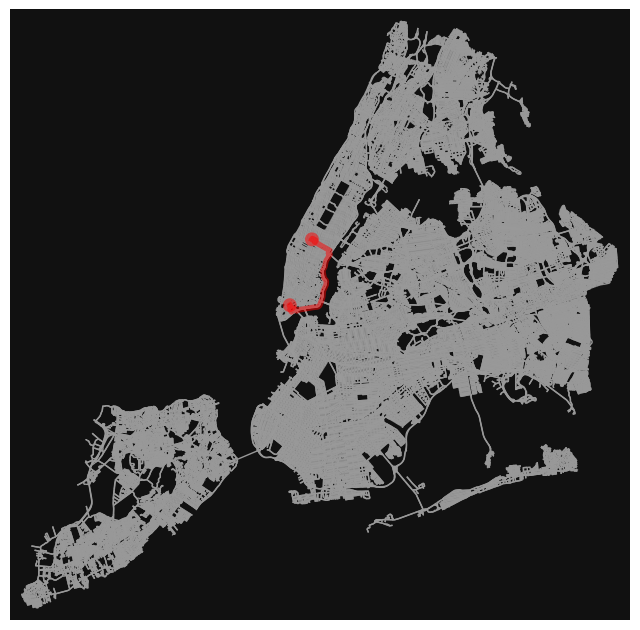

In [40]:
import matplotlib.pyplot as plt
fig, ax = ox.plot_graph_route(G, route, node_size=0)
plt.show()